In [1]:
pip install -U sentence-transformers cleanlab hdbscan umap umap-learn[plot] wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.5/157.5 KB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 17.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.5 MB/s eta 0:00:00
  Pre

In [15]:
# IMPORTS

from cleanlab.outlier import OutOfDistribution
from enum import Enum
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from PIL import Image
from sentence_transformers import SentenceTransformer
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer, ENGLISH_STOP_WORDS
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score, silhouette_score
from sklearn.preprocessing import StandardScaler
from transformers import AutoTokenizer, AutoModel
from umap.umap_ import INT32_MAX
from wordcloud import WordCloud
from yellowbrick.cluster import SilhouetteVisualizer

import cleanlab
import gzip
import hdbscan
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import re
import sklearn.cluster as cluster
import string
import torch
import torch.nn.functional as F
import umap
import unicodedata

nltk.download('averaged_perceptron_tagger') 
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [24]:
# Constants
URL = "https://raw.githubusercontent.com/yahya010/DocClustering/main/Pres_Speeches/presidential_speeches.csv"
stop_words = set(stopwords.words('english')) # switched to sklearn as it is larger than nltk stopwords
dataset = pd.read_csv(URL)
p = 0.65 #increase p = no of segments decreases

# Initialization
SEPERATE_BY_PRES = False

# Pre-Processing
MIN_SENTENCE_WORDS = 5
PLOT_SPEECHLEN_HIST = True
MIN_SPEECH_SENTENCE_COUNT = 10 # 10 sentences needed for cleanlab embedding

# Cleanlab
LOAD_FROM_CSV = True
EMBEDDING_CSV_DIRECTORY = 'Data_Output/ModernPresidents'
OUTLIER_SCORE_CUTOFF = 0.5
PRINT_CLEANLAB_ANALYSIS = True

# KMeans
CLUSTER_RANGE = range(2, 51)

# Create data output directory if needed
if not os.path.exists('Data_Output'):
   # Create a new directory because it does not exist
   os.makedirs('Data_Output')


## REF: https://colab.research.google.com/github/gal-a/blog/blob/master/docs/notebooks/nlp/nlp_tf-idf_clustering.ipynb#scrollTo=EbAMAIFFV_xh

# List of Presidents
class PresidentIndex(Enum):
  George_Washington = 0
  John_Adams = 1
  Thomas_Jefferson = 2
  James_Madison = 3
  James_Monroe = 4
  John_Quincy_Adams = 5
  Andrew_Jackson = 6
  Martin_Van_Buren = 7
  William_Harrison = 8
  John_Tyler = 9
  James_Polk = 10
  Zachary_Taylor = 11
  Millard_Fillmore = 12
  Franklin_Pierce = 13
  James_Buchanan = 14
  Abraham_Lincoln = 15
  Andrew_Johnson = 16
  Ulysses_Grant = 17
  Rutherford_Hayes = 18
  James_Garfield = 19
  Chester_Arthur = 20
  Grover_Cleveland_1 = 21
  Benjamin_Harrison = 22
  Grover_Cleveland_2 = 23
  William_McKinley = 24
  Theodore_Roosevelt = 25
  William_Taft = 26
  Woodrow_Wilson = 27
  Warren_Harding = 28
  Calvin_Coolidge = 29
  Herbert_Hoover = 30
  Franklin_Roosevelt = 31
  Harry_Truman = 32
  Dwight_Eisenhower = 33 
  John_Kennedy= 34
  Lyndon_Johnson = 35
  Richard_Nixon = 36
  Gerald_Ford = 37
  James_Carter = 38
  Ronald_Reagan = 39
  George_Bush_SR = 40
  William_Clinton = 41
  George_Bush = 42
  Barack_Obama = 43
  Donald_Trump = 44

# Set Presidents to use
PRESIDENTS = [PresidentIndex.Ronald_Reagan, PresidentIndex.George_Bush_SR, PresidentIndex.William_Clinton, PresidentIndex.George_Bush, PresidentIndex.Barack_Obama, PresidentIndex.Donald_Trump];
PRESIDENT_NAMES = [n.name for n in PRESIDENTS]

# Get stopwords, stemmer and lemmatizer
stemmer = nltk.stem.PorterStemmer()
lemmatizer = nltk.stem.WordNetLemmatizer()
general_stopwords = ENGLISH_STOP_WORDS  # note: sklearn has a longer list than nltk.corpus.stopwords.words('english')
additional_stopwords = []


# Get data samples and associated president
speeches = []
speech_classes = []

## TODO: VERIFY ALL PRES NAMES MATCH
# Tested: Washington, Lincoln

for index, row in dataset.iterrows():
  underscoreName = row['President'].replace(' ', '_')
  
  if underscoreName in PRESIDENT_NAMES:
    speeches.append(row['Transcript'])
    speech_classes.append(PresidentIndex[underscoreName].value)


Number of Speeches Processed: 128
Filtered 0 speeches (under 10 sentences in total length)


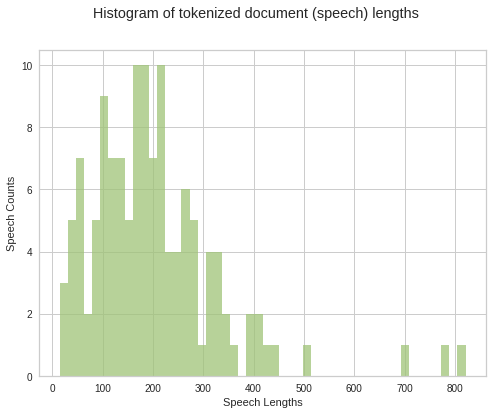

In [5]:
# Pre-Processing

pre_processed_speeches = []
list_token_lists = []


exclude = string.punctuation.replace(".", "")
exclude = exclude.replace("!", "")
exclude = exclude.replace("?", "")

# Pre-Processing Helpers
def remove_accents(data):
    return ''.join(x for x in unicodedata.normalize('NFKD', data) if x in string.ascii_letters or x == " ")
  
def remove_misc(data):
  return data.replace('\n', '')

stop_words = set(stopwords.words('english'))
speech_lengths = []

for i, speech in enumerate(speeches):

  # Tokenize by sentence, then by lowercase word
  sent_count = 0
  pre_processed_speech_sentences = []

  for sentence in nltk.sent_tokenize(speech):
    token_list = []
    
    if len(nltk.word_tokenize(sentence)) < MIN_SENTENCE_WORDS:
      continue

    tokens = []
    sent_count += 1

    for word in nltk.word_tokenize(sentence):
      t = word.lower()
      t = remove_accents(t)
      t = remove_misc(t)
      t = str(t).translate(string.punctuation)
      t = t.translate(str.maketrans('', '', exclude))

      token_list.append(t)

    pre_processed_speech_sentences.append(' '.join(token_list))
  
  if sent_count >= MIN_SPEECH_SENTENCE_COUNT:
    speech_lengths.append(sent_count)
    pre_processed_speeches.append(pre_processed_speech_sentences)
  
print(f'Number of Speeches Processed: {len(pre_processed_speeches)}')
print(f'Filtered {len(speeches) - len(pre_processed_speeches)} speeches (under 10 sentences in total length)')

df_speeches = pd.DataFrame(list_token_lists)

# Plot histogram of tokenized document lengths
if PLOT_SPEECHLEN_HIST:
  fig = plt.figure(figsize=(8,6))
  plt.suptitle("Histogram of tokenized document (speech) lengths")
  plt.xlabel("Speech Lengths")
  plt.ylabel("Speech Counts")
  n, bins, patches = plt.hist(speech_lengths, bins=50, density=False, facecolor='g', alpha=0.75)
  plt.show()

In [6]:
# Running Cleanlab 
# Filters unrelated sentences from each individual speech

if LOAD_FROM_CSV:
  post_cleanlab_sentences_df = pd.read_csv(EMBEDDING_CSV_DIRECTORY + '')

else:
  # Filtered speeches = list of every useful sentence across every speech of the selected president(s)
  post_cleanlab_speeches = []
  post_cleanlab_sentences = []

  # Embedding and outlier removal
  model = SentenceTransformer('sentence-transformers/all-mpnet-base-v1')

  filtered_sent_percentages = []

  for speech in pre_processed_speeches:
    try:
      ood = OutOfDistribution()
      original_embeddings = model.encode(speech)
      train_outlier_scores = ood.fit_score(features=original_embeddings)
      # get outlier id's for sentences with outlier scores below cutoff value
      outlier_ids = [i for i, outlier_score in enumerate(train_outlier_scores) if outlier_score < OUTLIER_SCORE_CUTOFF]
      
      if PRINT_CLEANLAB_ANALYSIS:
        filtered_sentences = [s for i, s in enumerate(speech) if i in outlier_ids]
        filtered_percent = round((len(filtered_sentences) / len(speech)) * 100) 
        filtered_sent_percentages.append(filtered_percent)


        print(f'Percentage of Sentences Filtered: {filtered_percent}')
        print("Filtered Sentences:")
        for s in filtered_sentences:
          print(f'{s}')
        print("\n\n")

      speech = [s for i, s in enumerate(speech) if i not in outlier_ids]

      post_cleanlab_speeches.append(speech)
      for sentence in speech:
        post_cleanlab_sentences.append(sentence)
    except:
      continue
    


  filtered_speech_embeddings = model.encode(post_cleanlab_sentences)

  if PRINT_CLEANLAB_ANALYSIS:
    print(f'Unfiltered Speech Shape: {model.encode(pre_processed_speeches).shape}')
    print(f'Filtered Speech Shape: {filtered_speech_embeddings.shape}')

    print(f'Average percentage of filtered sentences per speech (cutoff value  of {OUTLIER_SCORE_CUTOFF}): {sum(filtered_sent_percentages) / len(filtered_sent_percentages)}')

Fitting OOD estimator based on provided features ...
Percentage of Sentences Filtered: 17
Filtered Sentences:
thank you very much 
thank you and good evening 
the sponsor has been identified  but unlike most television programs  the performer has nt been provided with a script 
i recently have seen fit to follow another course 
not too long ago  two friends of mine were talking to a cuban refugee  a businessman who had escaped from castro  and in the midst of his story one of my friends turned to the other and said   we do nt know how lucky we are  and the cuban stopped and said   how lucky you are 
but they ve been a little more explicit in the past and among themselves  and all of the things i now will quote have appeared in print 
these are not republican accusations 
we have so many people who ca nt see a fat man standing beside a thin one without coming to the conclusion the fat man got that way by taking advantage of the thin one 
but the reverse is true 
well that was probably t

In [7]:
# PCA-95 Dimensionality Reduction
pca = PCA(n_components=0.95)
reduced_embedding = pca.fit_transform([f for f in filtered_speech_embeddings])
print(reduced_embedding.shape)

(24027, 333)


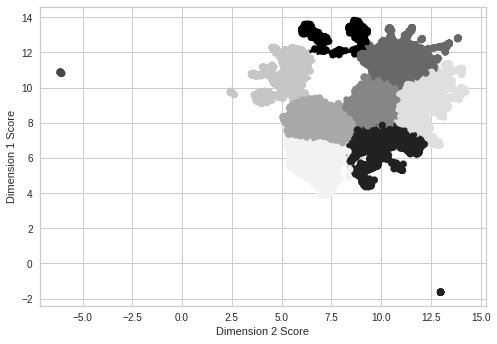

In [8]:
#Umap Clustering

reducer = umap.UMAP(n_components=2)
sentences_embeddings_reduced = reducer.fit_transform(filtered_speech_embeddings)

# Apply KMeans clustering to the reduced embeddings
kmeans = KMeans(n_clusters=10)
kmeans.fit(sentences_embeddings_reduced)

# Get the cluster labels for each sentence
labels = kmeans.labels_
plt.scatter(sentences_embeddings_reduced[:, 0], sentences_embeddings_reduced[:, 1], c=labels)
plt.xlabel('Dimension 2 Score')
plt.ylabel('Dimension 1 Score')
plt.show()


In [25]:
# Create data output directory if needed
export_dir = 'Data_Output/ModernPresidents'
if not os.path.exists(export_dir):
   # Create a new directory because it does not exist
   os.makedirs(export_dir)

def exp_to_gzip_csv(data, path):
  speech_embedding_df = pd.DataFrame(data)
  speech_embedding_df.to_csv(path, compression='gzip')

exp_to_gzip_csv(filtered_speech_embeddings, export_dir + '/SentenceEmbeddings.csv.gz')
exp_to_gzip_csv(post_cleanlab_speeches, export_dir + '/PostCleanlabSpeeches.csv.gz')
exp_to_gzip_csv(post_cleanlab_sentences, export_dir + '/PostCleanlabSentences.csv.gz')

# New Section

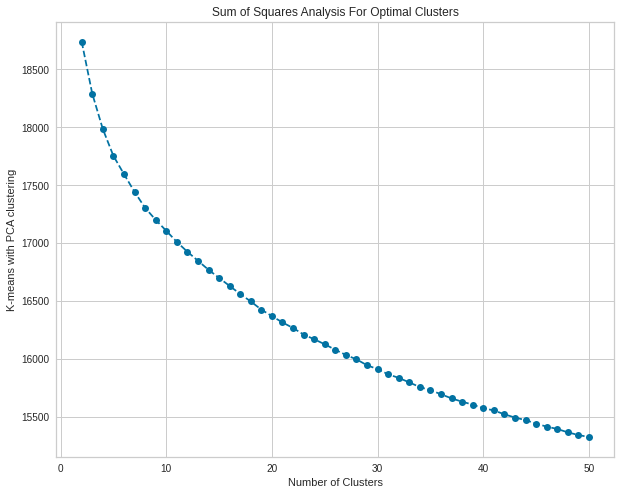

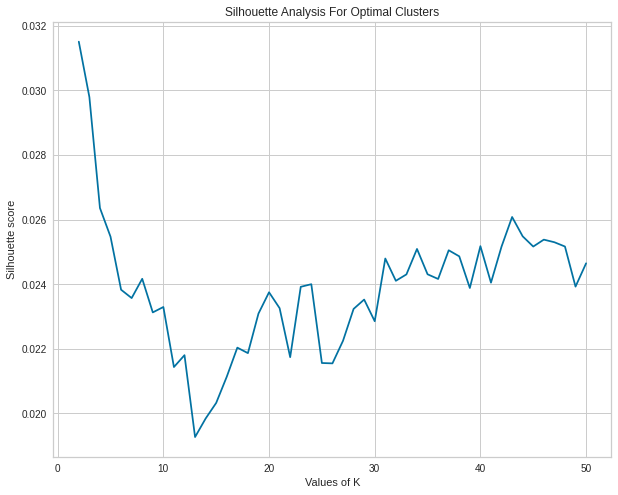

In [9]:
# Uses two metrics (sum of squares and silhouette score) to assist in determining optimal cluster size

def kmeans_optimal_clusters(reduced_embedding, fullTranscripts, cluster_range):

    # Comparison of Within Cluster Sum of Squares (wcss) for different cluster sizes
    wcss = []
    silhouette_avg = []


    for i in cluster_range:
        km = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
        km.fit(reduced_embedding)
        wcss.append(km.inertia_)
        silhouette_avg.append(silhouette_score(reduced_embedding, km.labels_, metric='euclidean', random_state=42))

    # Sum of Squares Plot
    plt.figure(figsize=(10, 8))
    plt.plot(cluster_range, wcss, marker='o', linestyle='--')
    plt.xlabel('Number of Clusters')
    plt.ylabel('K-means with PCA clustering')
    plt.title('Sum of Squares Analysis For Optimal Clusters')
    plt.show()


    # Silhouette Plot
    plt.figure(figsize=(10, 8))
    plt.plot(cluster_range, silhouette_avg, 'bx-')
    plt.xlabel('Values of K')
    plt.ylabel('Silhouette score')
    plt.title('Silhouette Analysis For Optimal Clusters')
    plt.show()


kmeans_optimal_clusters(reduced_embedding, post_cleanlab_speeches, CLUSTER_RANGE)

In [ ]:
# Segmentation
segmentation  = get_optimal_splits(embeddings, p) # Splits.
segmented_txt = get_segmented_sentences(filteredTranscript, segmentation)
segment_list = []
for segment in segmented_txt:
    segment_list.append('Segment ' + str(segmented_txt.index(segment)) + ': ' + str(segment))

seglistDF = pd.DataFrame(segment_list)
seglistDF.to_csv('fullSegmentationList.csv')

In [ ]:
def squared_sum(x):
  """ return 3 rounded square rooted value """
  return round(np.sqrt(sum([a*a for a in x])),3)

def cos_similarity(x,y):
  """ return cosine similarity between two lists """
  numerator = sum(a*b for a,b in zip(x,y))
  denominator = squared_sum(x)*squared_sum(y)
  return round(numerator/float(denominator),3)

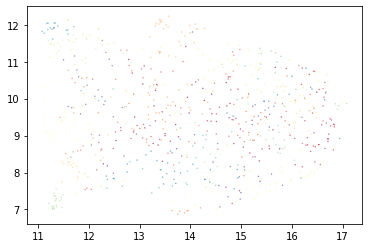

In [ ]:
kmeans_labels = cluster.KMeans(n_clusters=30).fit_predict(reduced_embedding)
standard_embedding = umap.UMAP(random_state=42).fit_transform(reduced_embedding)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=kmeans_labels, s=0.1, cmap='Spectral')

In [ ]:
def color_func(word=None, font_size=None,
                     position=None, orientation=None,
                     font_path=None, random_state=None):
    colors = [[4, 77, 82],
              [25, 74, 85],
              [82, 43, 84],
              [158, 48, 79]]
    rand = random_state.randint(0, len(colors) - 1)
    return "hsl({}, {}%, {}%)".format(colors[rand][0], colors[rand][1], colors[rand][2])

['disapprobation', 'lear', 'postmaster', 'printers', 'representations', 'gotten', 'lacking', 'lengths', 'lick', 'mill', 'mortices', 'omitting', 'tenons', 'workmen', 'accustoming', 'actively', 'alienate', 'artifices', 'collective', 'covertly', 'dawning', 'discountenancing', 'foresee', 'fortress', 'frowning', 'immovable', 'indignantly', 'infinite', 'insidiously', 'link', 'palladium', 'ad', 'eighth', 'offor', 'diversifying', 'gentle', 'ingratitude', 'preferences', 'dispense', 'amsterdam', 'antwerp', 'achieve', 'bind', 'bondsman', 'charity', 'finish', 'lash', 'lord', 'orphan', 'sunk']


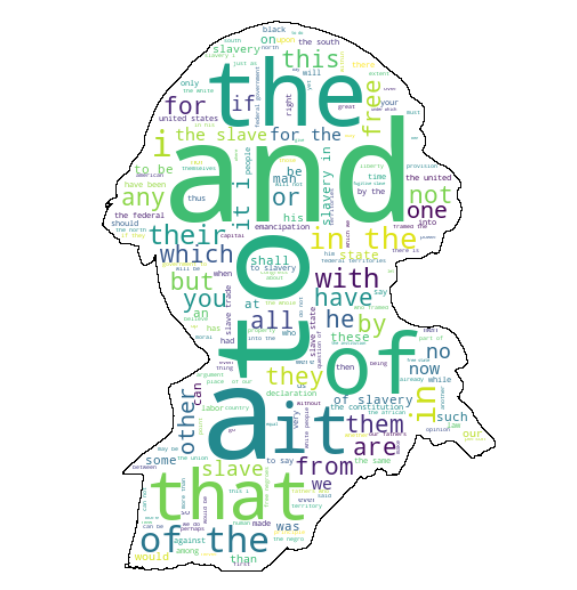

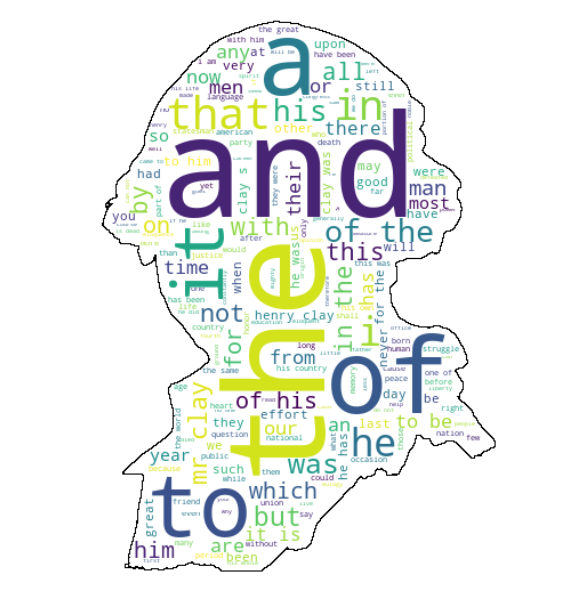

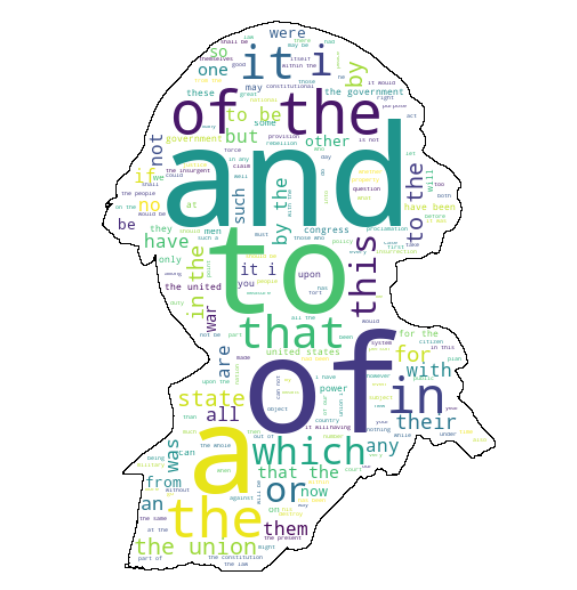

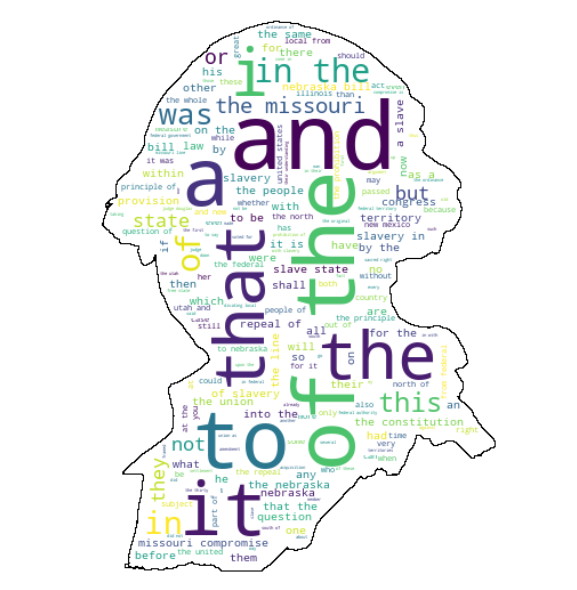

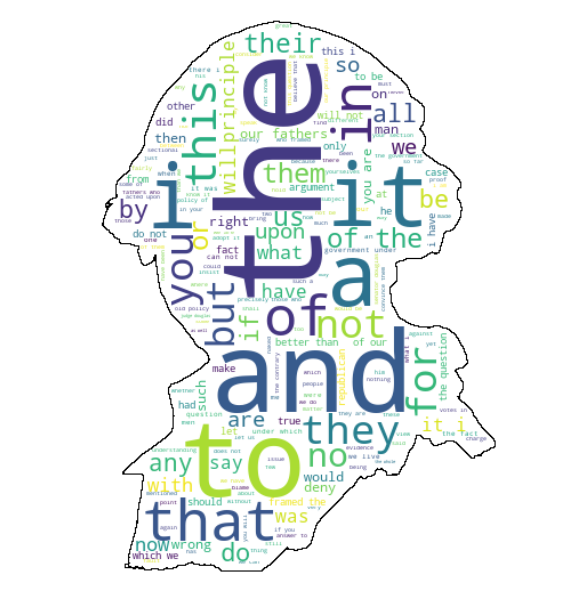

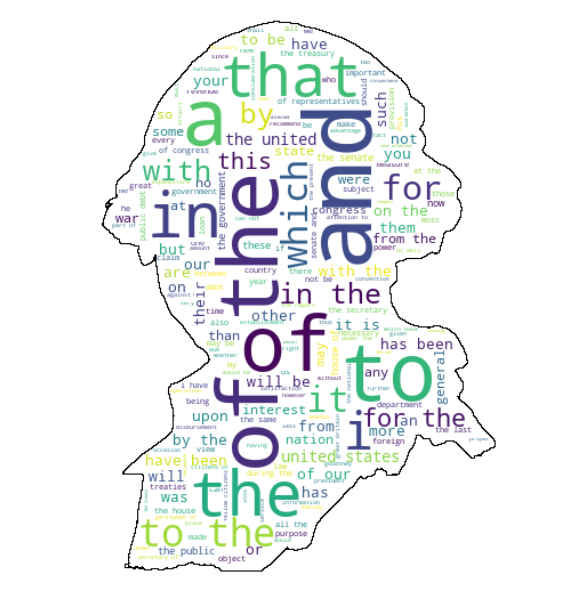

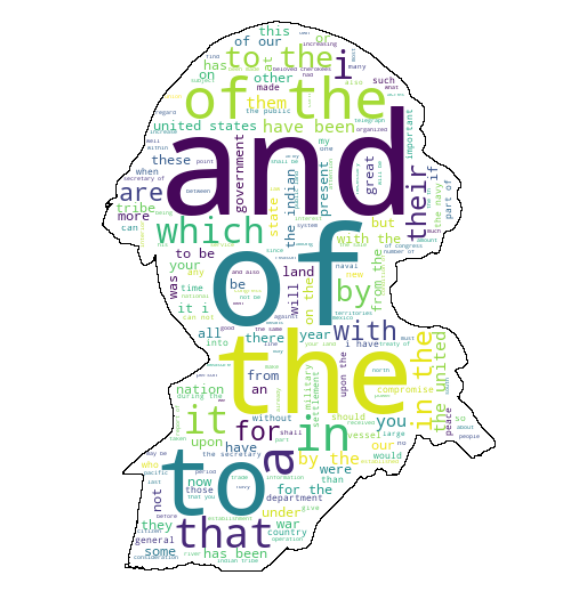

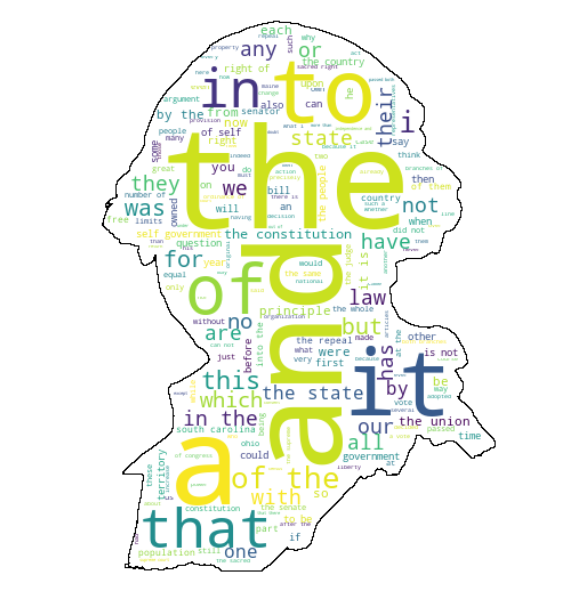

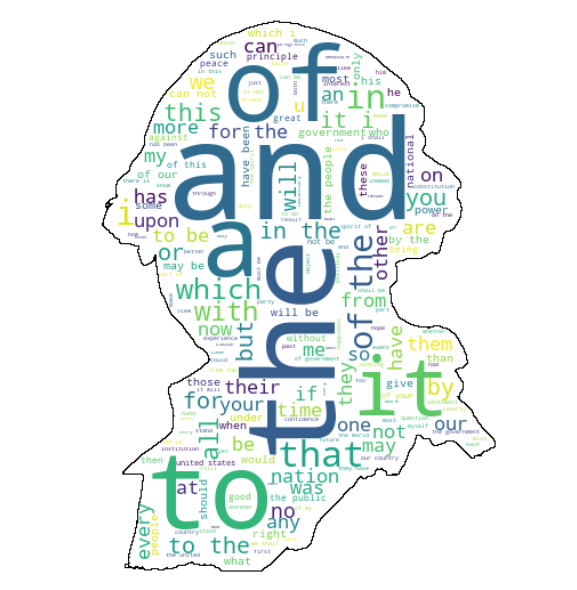

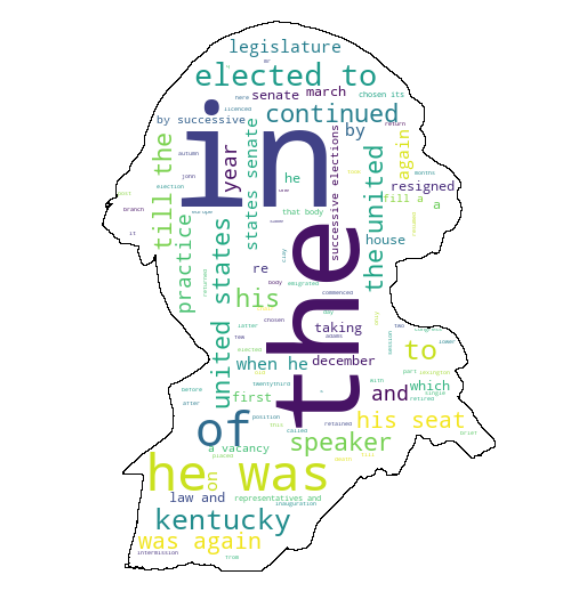

In [ ]:
#Original method - probably using this

# Your list of tokenized sentences

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(post_cleanlab_sentences)

# Get the words and their tf-idf scores
feature_names = tfidf_vectorizer.get_feature_names_out()
scores = tfidf_matrix.toarray().mean(axis=0)

# Sort the words by their tf-idf scores
sorted_words = sorted(zip(feature_names, scores), key=lambda x: x[1])

# Print the 50 words with the lowest tf-idf scores
# print("50 words with the lowest tf-idf scores:")
# print(sorted_words[:50])
lowest_tfidf_words = []
for word, score in sorted_words[:50]:
    lowest_tfidf_words.append(word)
#     print(f"{word}: {score:.4f}")
print(lowest_tfidf_words)

#print(len(filteredTranscript))
#low_tfidf = lowest_tfidf_words(filteredTranscript)
#print(len(lowest_tfidf_words(filteredTranscript)))
mask = np.array(Image.open('gw.png'))

for i in range(kmeans.n_clusters):
    # Get the indices of sentences belonging to the current cluster
    cluster_indices = np.where(labels == i)[0]
    cluster_sentences = [post_cleanlab_sentences[index] for index in cluster_indices]

    # Combine the sentences into a single string
    cluster_text = " ".join(cluster_sentences)
    cluster_text =" ".join([ word for word in cluster_text.split() if word.lower() not in lowest_tfidf_words])
    # Generate a word cloud from the cluster text


    wordcloud = WordCloud(min_font_size=4, 
                          mask=mask,
                          width=mask.shape[1],
                          height=mask.shape[0],
                          stopwords=lowest_tfidf_words, 
                          background_color="white",
                          contour_width=1,
                          contour_color="black")
    wordcloud.generate(cluster_text)

    # Plot the word cloud
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.tight_layout(pad=0)

    plt.show()

In [ ]:
# PrePCA Cosine Similarity Matrix
heatmap = np.zeros(shape=(len(embeddings), len(embeddings)))
for i in range(len(embeddings)):
    sent = embeddings[i]
    for j in range(len(embeddings)):
        sent2 = embeddings[j]
        cosSim = cos_similarity(sent, sent2)
        heatmap[i,j] = cosSim

In [ ]:
# PostPCA Cosine Similarity Matrix (Sentence Similarity Matrix)
heatmapPost = np.zeros(shape=(len(reduced_embedding), len(reduced_embedding)))
for i in range(len(reduced_embedding)):
    sentPost = reduced_embedding[i]
    for j in range(len(reduced_embedding)):
        sent2Post = reduced_embedding[j]
        cosSimPost = cos_similarity(sentPost, sent2Post)
        heatmapPost[i,j] = cosSimPost

[[1.    0.382 0.445 ... 0.284 0.194 0.26 ]
 [0.382 1.    0.519 ... 0.33  0.208 0.306]
 [0.445 0.519 1.    ... 0.406 0.348 0.261]
 ...
 [0.284 0.33  0.406 ... 1.    0.234 0.334]
 [0.194 0.208 0.348 ... 0.234 1.    0.207]
 [0.26  0.306 0.261 ... 0.334 0.207 1.   ]]
done with PrePCA heatmap


In [ ]:
# Prenormalized Heatmaps

# PrePCA Heatmap
x = 100
y = 100
heatmapPrePCA = np.zeros(shape=(y, x))
for i in range(y):
  for j in range(x):
    heatmapPrePCA[i,j] = heatmap[i,j]
data = heatmapPrePCA
plt.imshow( data , cmap = 'inferno' , vmax = .7, interpolation = 'nearest' )
# color schemes that work well (cmap =): cividis, viridis, inferno. Full list: https://matplotlib.org/stable/tutorials/colors/colormaps.html
plt.title( "Transcript 0: PrePCA Heatmap" )
plt.show()

# PostPCA Heatmap
x = 100
y = 100
heatmapPostPCA = np.zeros(shape=(y, x))
for i in range(y):
  for j in range(x):
    heatmapPostPCA[i,j] = heatmapPost[i,j]
data = heatmapPostPCA
plt.imshow( data , cmap = 'inferno' , vmax = .35, interpolation = 'nearest' )
# color schemes that work well (cmap =): cividis, viridis, inferno. Full list: https://matplotlib.org/stable/tutorials/colors/colormaps.html
plt.title( "Transcript 0: PostPCA Heatmap" )
plt.show()

In [ ]:
# Standardize the Data


heatmapStandard = StandardScaler().fit_transform(heatmap)
heatmapPostStandard = StandardScaler().fit_transform(heatmapPost)

# PrePCA Heatmap
x = 100
y = 100
heatmapPrePCAStandard = np.zeros(shape=(y, x))
for i in range(y):
  for j in range(x):
    heatmapPrePCAStandard[i,j] = heatmapStandard[i,j]
data = heatmapPrePCAStandard
plt.imshow( data , cmap = 'inferno' , vmax = 3, interpolation = 'nearest' )
# color schemes that work well (cmap =): cividis, viridis, inferno. Full list: https://matplotlib.org/stable/tutorials/colors/colormaps.html
plt.title( "Transcript 0: PrePCA Heatmap" )
plt.show()

# PostPCA Heatmap
x = 100
y = 100
heatmapPostPCAStandard = np.zeros(shape=(y, x))
for i in range(y):
  for j in range(x):
    heatmapPostPCAStandard[i,j] = heatmapPostStandard[i,j]
data = heatmapPostPCAStandard
plt.imshow( data , cmap = 'inferno' , vmax = 3, interpolation = 'nearest' )
# color schemes that work well (cmap =): cividis, viridis, inferno. Full list: https://matplotlib.org/stable/tutorials/colors/colormaps.html
plt.title( "Transcript 0: PostPCA Heatmap" )
plt.show()

In [ ]:
# Normalized Heatmaps

# Normalize Pre and Post Cosine Similarity Matrixs
heatmapmax, heatmapmin = heatmap.max(), heatmap.min()
heatmapPreNorm = (heatmap - heatmapmin)/(heatmapmax - heatmapmin)
heatmapPostmax, heatmapPostmin = heatmapPost.max(), heatmapPost.min()
heatmapPostNorm = (heatmapPost - heatmapPostmin)/(heatmapPostmax - heatmapPostmin)
# PrePCA Heatmap
x = 100
y = 100
heatmapPrePCANorm = np.zeros(shape=(y, x))
for i in range(y):
  for j in range(x):
    heatmapPrePCANorm[i,j] = heatmapPreNorm[i,j]
data = heatmapPrePCANorm
plt.imshow( data , cmap = 'inferno' , vmax = 0.6, interpolation = 'nearest' )
# color schemes that work well (cmap =): cividis, viridis, inferno. Full list: https://matplotlib.org/stable/tutorials/colors/colormaps.html
plt.title( "Transcript 0: PrePCA Normalized Heatmap" )
plt.show()

# PostPCA Heatmap
x = 100
y = 100
heatmapPostPCANorm = np.zeros(shape=(y, x))
for i in range(y):
  for j in range(x):
    heatmapPostPCANorm[i,j] = heatmapPostNorm[i,j]
data = heatmapPostPCANorm
plt.imshow( data , cmap = 'inferno' , vmax = 0.5, interpolation = 'nearest' )
# color schemes that work well (cmap =): cividis, viridis, inferno. Full list: https://matplotlib.org/stable/tutorials/colors/colormaps.html
plt.title( "Transcript 0: PostPCA Normalized Heatmap" )
plt.show()

In [ ]:
# Test Code

fullTranscripts = pd.DataFrame(fullTranscripts)
fullTranscripts.to_csv('fullTranscripts.csv')

embedding = pd.DataFrame(embedding)
embedding.to_csv('embedding.csv')

reduced_embedding = pd.DataFrame(reduced_embedding)
reduced_embedding.to_csv('reduced_embedding.csv')